<a href="https://colab.research.google.com/github/rafsantos/tcc_colab_py/blob/main/Convolucao%20PeB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Ferramentas
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import requests

# Função convolução
def convolve(image, filter):
  padding = (int(filter.shape[0]/2),int(filter.shape[1]/2))
  if(image.ndim == 2):
      image = np.expand_dims(image, axis=-1)
  if(filter.ndim == 2):
      filter = np.repeat(np.expand_dims(filter, axis=-1), image.shape[-1], axis=-1)
  if(filter.shape[-1] == 1):
      filter = np.repeat(filter, image.shape[-1], axis=-1)
  assert image.shape[-1] == filter.shape[-1]
  size_x, size_y = filter.shape[:2]
  width, height = image.shape[:2]
  padded_image = np.pad(image, [
      (padding[0], padding[0]),
      (padding[1], padding[1]),
      (0, 0)],mode='edge')

  output_array = image
  #Para fazer a animacao vou armazenar os frames em uma lista
  frames = []
  # So vou pegar 30 imagens de todo o processo
  keyFrame = int(image.shape[0]*image.shape[1]/30)
  count = 0
  for x in range(padded_image.shape[0] - size_x +1):
    for y in range(padded_image.shape[1] - size_y +1):
      # Janela movel do filtro
      window = padded_image[x:x + size_x, y:y + size_y]
      # Soma do produto da janela fo filtro e área da imagem
      output_values = np.sum(filter * window, axis=(0, 1))
      # Guarda resultado no array resultado
      output_array[x, y] = np.asarray(output_values)

      # Se for um frame para animacao, vou guardar
      if (count)%keyFrame == 0:
        if(output_array.shape[-1] == 1):
          output_array = output_array[:,:,0]
        img = Image.fromarray(output_array.astype('uint8'))
        frames.append(img)
      count += 1
  if(output_array.shape[-1] == 1):
    output_array = output_array[:,:,0]
  img = Image.fromarray(output_array.astype('uint8'))
  return output_array, frames

#Desenha grade em uma imagem com um determinado intervalo
def grade(img,intervalo):
  img = np.array(img)
  img[::intervalo] = 0
  img[:,::intervalo] = 0
  img = Image.fromarray(img.astype('uint8'),'L')
  return img

def leImagemWeb(url):
  im = Image.open(requests.get(url, stream=True).raw).convert('L')
  return im

#pixelando imagem
def ajustaVisual(img,pixH,fator):
  #compacta primeiro
  img = encolhe(img,pixH)
  img = img.resize((img.size[0]*fator,img.size[1]*fator),resample=Image.NEAREST)
  return img

#Reduz imagem para quantidade de pixels na horizontal
def encolhe(img,pixH):
  img = img.resize((pixH,int(pixH*img.height/img.width)),resample=Image.NEAREST)
  return img

# Escreve os pixels por cima da imagem ajustada a fator
def escrevePixels(img,fator):
  draw = ImageDraw.Draw(img)
  font = ImageFont.load_default()
  img_arr = np.transpose(np.array(img))
  for y in range(0,img_arr.shape[1],fator):
    for x in range(0,img_arr.shape[0],fator):
      txt = str((img_arr)[x,y])
      txtbox = font.getbbox(txt)
      #Alinhando o texto no centro do quadrado
      draw.text((x + fator/2 - txtbox[2]/2, y + fator/2 - txtbox[3]/2 ), txt, anchor='mm')
  return img

def animacaoGIF(frames_arr,fator):
  #Os frames sao uma lista de imagens de cada frae da animacao
  #Preciso ampliar cada um primeiro
  frames_out = []
  for frame in frames:
    #Para cada frame, vou ampliar e gravar na lista de saida

    frame = frame.resize((frame.size[0]*fator,frame.size[1]*fator),resample=Image.NEAREST)
    #display(frame)
    frames_out.append(frame)
  return frames_out


In [87]:
# @title Tipo de Filtro
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import requests

dropdown = 'Aresta H 5x5' #@param ["Blur 5x5","Blur 3x3", "Aresta H 3x3", "Aresta V 3x3", "Aresta H 5x5", "Aresta V 5x5"]

if dropdown == 'Blur 3x3':
  filtro = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
    ], dtype=np.float32)/9.0

if dropdown == 'Blur 5x5':
  filtro = np.array([
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1]
    ], dtype=np.float32)/16.0

if dropdown == 'Aresta H 3x3':
  filtro = np.array([
    [1, 0, 10],
    [1, 0, 10],
    [1, 0, 10],
    ], dtype=np.float32)/10.0

if dropdown == 'Aresta V 3x3':
  filtro = np.array([
    [10,  10, 10],
    [ 0,  0,   0],
    [ 1,  1,   1]
    ], dtype=np.float32)/30.0

if dropdown == 'Aresta H 5x5':
  filtro = np.array([
    [1, 1, 1, 10, 10],
    [1, 1, 1, 10, 10],
    [1, 1, 1, 10, 10],
    [1, 1, 1, 10, 10],
    [1, 1, 1, 10, 10]
    ], dtype=np.float32)/50.0

if dropdown == 'Aresta V 5x5':
  filtro = np.array([
    [10, 10, 10, 10, 10],
    [10, 10, 10, 10, 10],
    [1,  1,  1,  1,   1],
    [1,  1,  1,  1,   1],
    [1,  1,  1,  1,   1]
    ], dtype=np.float32)/50

In [91]:
fator = 1
pixHoriz = 600
# Vou obter uma imagem da web
#url = ("https://i.ibb.co/D81PNZz/image.png")
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSzFVq9sCTckUxKmHj7YTLlKQH6nkicNS_UQ9XUdvdeLg&s"
#url = 'https://live.staticflickr.com/4830/44200095760_4d993be1cb_b.jpg'

#foto do CCET
#url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS-b-t_tELBi5ZzcbcFHRuZgXl7GAHqec_4i7H6mg108BjGR89RlSCs2o5vkQfrytMUnA&usqp=CAU"
url = "https://www.unirio.br/ingresso-1/ccbs/ibio/fotos/predio-do-ibio/image"

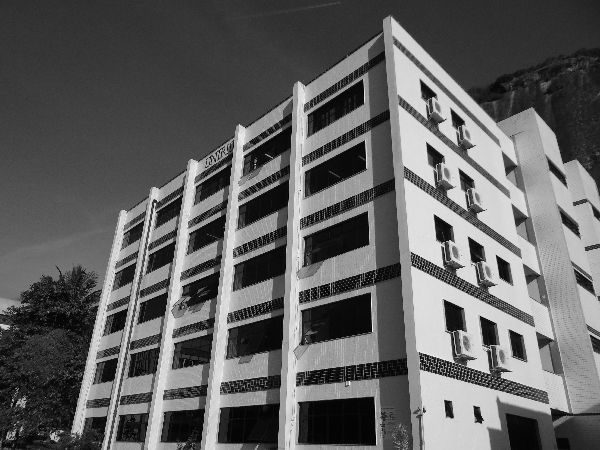

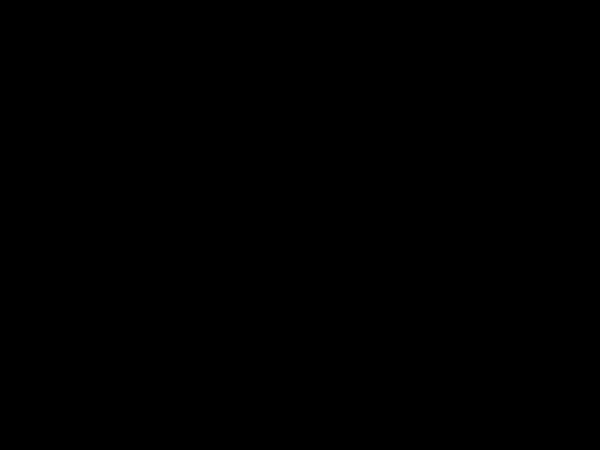

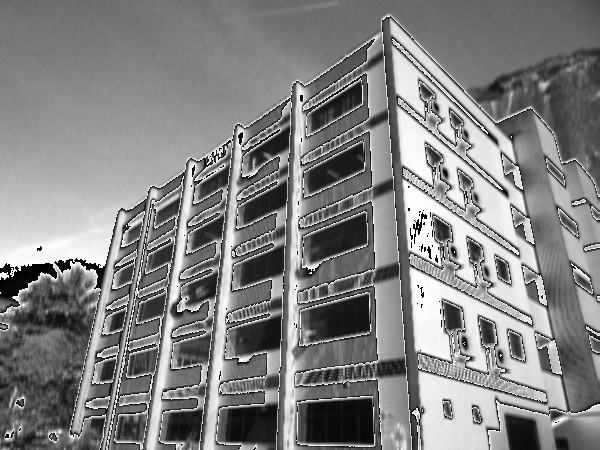

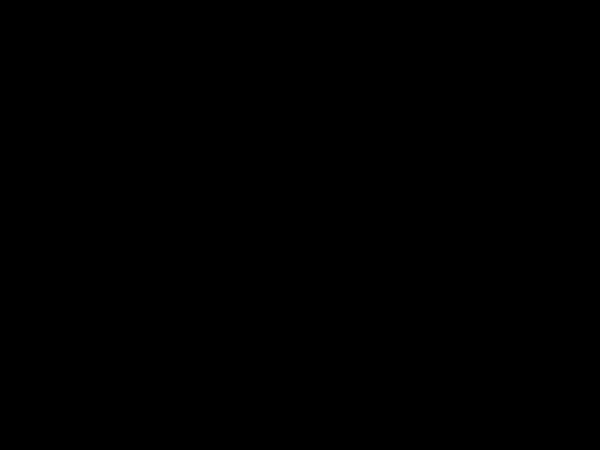

In [92]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import requests

def convolucao(image, filter):
   return image

##### Funcoes #########
# Função convolução

img = leImagemWeb(url)

#Ajustando exibicao da imagem de entrada
img_in = ajustaVisual(img,pixHoriz,fator)
display(img_in)
img_in = escrevePixels(img_in,fator)
img_in = grade(img_in,fator)
display(img_in)

#processando a imagem
img = encolhe(img,pixHoriz)
img_arr = np.array(img)
img_arr,frames = convolve(img_arr,filtro)
img = Image.fromarray(img_arr.astype('uint8'))
img = ajustaVisual(img,pixHoriz,fator)

#
#escrevendo os valores de cada pixel

display(img)
img = escrevePixels(img,fator)

#Desenha grade
img = grade(img,fator)
print('')
display(img)


frames = animacaoGIF(frames,fator)
frames[0].save('saida.gif', format='GIF', append_images=frames[1:], save_all=True, duration=100, loop=0)
